In [1]:
import pandas as pd
import numpy as np
import os
from dateutil import parser
import matplotlib.pyplot as plt

In [2]:
def extract_date(text):
    try:
        return parser.parse(text, fuzzy=True, ignoretz=True).date()
    except:
        return pd.NA

In [3]:
def plot_articles_per_year(df):
    # Convert 'Date' to datetime and extract year
    df['Year'] = pd.to_datetime(df['Date']).dt.year
    # Count the number of articles per year
    articles_per_year = df['Year'].value_counts().sort_index()
    # Plot
    fig, ax = plt.subplots(figsize=(10, 5))
    articles_per_year.plot(kind='bar', ax=ax)
    plt.title('Number of articles per year')
    plt.xlabel('Year')
    plt.ylabel('Number of articles')
    # Reduce the number of xticks
    ax.set_xticks(ax.get_xticks()[::int(len(ax.get_xticks())/10)])
    plt.show()

def plot_articles_per_year_month(df):
    # Convert 'Date' to datetime, extract year and month
    df['Year'] = pd.to_datetime(df['Date']).dt.year
    df['Month'] = pd.to_datetime(df['Date']).dt.month
    # Group by year and month and count the number of articles
    articles_per_year_month = df.groupby(['Year', 'Month']).size().unstack().fillna(0)
    # Plot
    fig, ax = plt.subplots(figsize=(10, 5))
    articles_per_year_month.plot(kind='bar', stacked=True, ax=ax)
    plt.title('Number of articles per year per month')
    plt.xlabel('Year')
    plt.ylabel('Number of articles')
    # Reduce the number of xticks
    ax.set_xticks(ax.get_xticks()[::int(len(ax.get_xticks())/10)])
    plt.show()

In [4]:
DATA_PATH = '../data/'

In [5]:
files = [file for file in os.listdir(DATA_PATH) if file.endswith('.csv')]
files

['data_1990_to_2000.csv',
 'data_1960_to_1980.csv',
 'data_2010_to_2023.csv',
 'data_2000_to_2010.csv',
 'data_1966_to_1971.csv',
 'data_1980_to_1990.csv',
 'data_1900_to_1960.csv',
 'data_1960_to_1965.csv',
 'data_1972_to_1979.csv']

In [6]:
dfs = []
for file in files:
    temp = pd.read_csv(os.path.join(DATA_PATH, file))
    temp = temp.iloc[:, :4]
    dfs.append(temp)

df = pd.concat(dfs, ignore_index=True)
df = df.dropna()
df.loc[:, 'Date'] = df['Date'].apply(extract_date)
df = df.dropna()
df = df.loc[:, ['Date', 'Title', 'Body']]
df = df.sort_values('Date', ignore_index=True)
df = df.drop_duplicates()

In [7]:
df

,Date,Title,Body
0,1900-04-21,"Address at Ecumenical Conference, New York",Words of welcome are unnecessary here. This re...
1,1900-12-03,State of the Union Message,"EXECUTIVE MANSION, December 3, 1900To the Sena..."
2,1900-12-31,"Theodore Roosevelt, An Autobiography With Illu...","It was still the Wild West in those days, the ..."
3,1900-12-31,"Theodore Roosevelt, An Autobiography With Illu...",APPENDIX A\nCONSERVATIONAPPENDIX B\nTHE POLITI...
4,1901-01-01,"Theodore Roosevelt, An Autobiography With Illu...",I am reluctant to say anything whatever about ...
...,...,...,...
15583,2023-12-31,"At These Schools, Arab and Jewish Students Sha...",In a classroom decorated with Hebrew and Arabi...
15584,2023-12-31,Can an Ambitious Public University Be a Place ...,"Shortly after she became governor of New York,..."
15585,2023-12-31,Tina Turner's Famous Body Was a Mirage,Tina Turner B. 1939Her famous shape was sculpt...
15586,2023-12-31,It's a Herculean Task to Keep Up in the Age of...,At the center of 2023's ''The Marvels'' is Car...


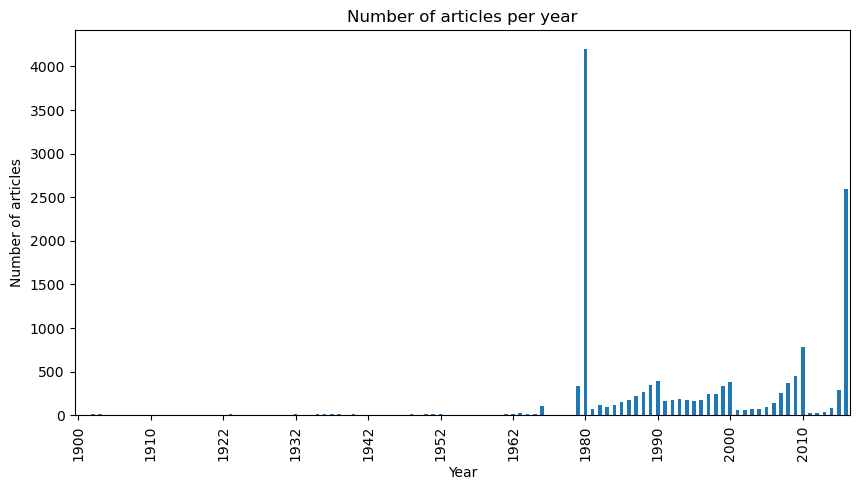

In [8]:
plot_articles_per_year(df)

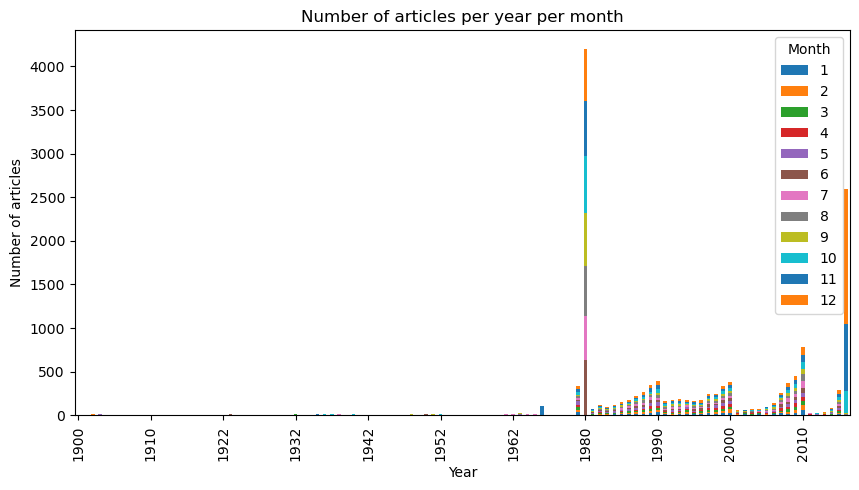

In [9]:
plot_articles_per_year_month(df)

In [10]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from tqdm.auto import tqdm
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import pos_tag
from nltk.chunk import ne_chunk
from nltk.tree import Tree
import spacy

In [11]:
class TextAnalysis:
    def __init__(self, dataframe):
        self.df = dataframe
        self.decade_frequency = {}
        self.nlp = spacy.load("en_core_web_lg")

    def clean_text(self, text):
        text = text.lower()  # Convert to lowercase
        text = re.sub(r'\d+', '', text)  # Remove numbers
        text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        return text

    def preprocess(self):
        tqdm.pandas(desc="Cleaning text")
        self.df['Body'] = self.df['Body'].progress_apply(self.clean_text)
        self.df['Date'] = pd.to_datetime(self.df['Date'])
        self.df['Decade'] = self.df['Date'].dt.year // 10 * 10  # Get decade

    def tokenize_and_count(self, texts):
        stop_words = set(stopwords.words('english'))
        all_tokens = word_tokenize(' '.join(texts))  # Combine texts and tokenize
        tokens = [word for word in all_tokens if word not in stop_words and word.isalpha()]  # Filter out stop words and punctuation
        return Counter(tokens)

    def analyze_frequency(self):
        grouped = self.df.groupby('Decade')['Body']
        for decade, texts in tqdm(grouped, desc="Tokenizing and counting"):
            self.decade_frequency[decade] = self.tokenize_and_count(texts.tolist())

    def count_community(self):
        return {decade: freq.get('community', 0) for decade, freq in tqdm(self.decade_frequency.items(), desc="Counting 'community'")}

    def sentiment_analysis(self, text):
        sid = SentimentIntensityAnalyzer()
        return sid.polarity_scores(text)

    def named_entity_recognition(self, text):
        max_length = 1000000  # Set a chunk size that is manageable
        results = []
        for start in range(0, len(text), max_length):
            # Process text in chunks that fit within the max_length limit
            chunk = text[start:start + max_length]
            doc = self.nlp(chunk)
            results.extend([(ent.text, ent.label_) for ent in doc.ents])
        return results

    def perform_advanced_analysis(self):
        # This method can be expanded to perform a detailed analysis per decade or as needed.
        results = {}
        for decade, texts in tqdm(self.df.groupby('Decade')['Body'], desc="Advanced Analysis"):
            combined_texts = ' '.join(texts.tolist())
            sentiment = self.sentiment_analysis(combined_texts)
            named_entities = self.named_entity_recognition(combined_texts)
            results[decade] = {
                'sentiment': sentiment,
                'named_entities': named_entities
            }
        return results

In [12]:
text_analysis = TextAnalysis(df)

In [13]:
text_analysis.preprocess()

Cleaning text:   0%|          | 0/14664 [00:00<?, ?it/s]

In [14]:
text_analysis.analyze_frequency()

Tokenizing and counting:   0%|          | 0/13 [00:00<?, ?it/s]

In [15]:
community_counts = text_analysis.count_community()
community_counts

Counting 'community':   0%|          | 0/13 [00:00<?, ?it/s]

{1900: 121,
 1910: 42,
 1920: 70,
 1930: 178,
 1940: 127,
 1950: 131,
 1960: 142,
 1970: 1715,
 1980: 13731,
 1990: 12710,
 2000: 8790,
 2010: 5152,
 2020: 7617}

In [ ]:
advanced_analysis_results = text_analysis.perform_advanced_analysis()
advanced_analysis_results

Advanced Analysis:   0%|          | 0/13 [00:00<?, ?it/s]